In [1]:
import json

In [7]:
new_file = open("./data.json", 'wt')
data = []
with open('./Sarcasm_Headlines_Dataset.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
new_file.write(json.dumps(data))   
new_file.close()

In [15]:
def remove_stop_words(string):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    query = string.lower().split(' ')
    res = [x for x in query if x not in stopwords]
    return ' '.join(res)

sentences = []
labels = []

with open('./data.json', 'r') as file:
    f = json.load(file)
    for item in f:
        sentences.append(remove_stop_words(item['headline']))
        labels.append(item['is_sarcastic'])

In [29]:
import numpy as np
def split_train_test(sentences, labels, split_size):
    train_length = int(len(sentences) * split_size)
    test_length = len(sentences) - train_length
    
    train_sentences = sentences[0:train_length]
    test_sentences = sentences[-test_length:]
    
    train_labels = labels[0:train_length]
    test_labels = labels[-test_length:]
    
    return (train_sentences, np.array(train_labels)), (test_sentences, np.array(test_labels))

(train_sentences, train_labels), (test_sentences, test_labels) = split_train_test(sentences, labels, 0.9)

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocabulary_size = 10000
embedding_dim = 16
max_length = 32
padding_type = "post"
truncating_type = "post"
oov_token = "<OOV>"

tk = Tokenizer(num_words=vocabulary_size, oov_token=oov_token)
tk.fit_on_texts(train_sentences) # creating tk.word_index
train_sequences = tk.texts_to_sequences(train_sentences)
train_sequences_padded = pad_sequences(train_sequences, 
                                       maxlen=max_length, 
                                       padding=padding_type, 
                                       truncating=truncating_type)

test_sequences = tk.texts_to_sequences(test_sentences)
test_sequences_padded = pad_sequences(test_sequences,     
                                      maxlen=max_length, 
                                      padding=padding_type, 
                                      truncating=truncating_type)

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(vocabulary_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(), # instead of Flatten()
    layers.Dense(units=24, activation=tf.nn.relu),
    layers.Dense(units=1, activation=tf.nn.sigmoid),
])

In [41]:
from tensorflow.keras import optimizers, losses

model.compile(
    optimizer=optimizers.Adam(), 
    loss=losses.binary_crossentropy, 
    metrics=['accuracy'])

In [42]:
num_epochs = 10
history = model.fit(
    x=train_sequences_padded, 
    y=train_labels, 
    epochs=num_epochs,
    validation_data=(test_sequences_padded, test_labels))

Epoch 1/10


2022-03-19 22:19:21.560986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


805/805 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.6855

2022-03-19 22:19:29.864886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


805/805 [==============================] - 9s 11ms/step - loss: 0.5906 - accuracy: 0.6855 - val_loss: 0.4439 - val_accuracy: 0.7844
Epoch 2/10
805/805 [==============================] - 8s 10ms/step - loss: 0.3645 - accuracy: 0.8416 - val_loss: 0.4091 - val_accuracy: 0.7998
Epoch 3/10
805/805 [==============================] - 8s 10ms/step - loss: 0.2917 - accuracy: 0.8785 - val_loss: 0.4111 - val_accuracy: 0.8148
Epoch 4/10
805/805 [==============================] - 8s 10ms/step - loss: 0.2529 - accuracy: 0.8967 - val_loss: 0.4349 - val_accuracy: 0.8131
Epoch 5/10
805/805 [==============================] - 8s 10ms/step - loss: 0.2277 - accuracy: 0.9079 - val_loss: 0.4604 - val_accuracy: 0.8092
Epoch 6/10
805/805 [==============================] - 8s 10ms/step - loss: 0.2090 - accuracy: 0.9161 - val_loss: 0.4976 - val_accuracy: 0.8061
Epoch 7/10
805/805 [==============================] - 8s 10ms/step - loss: 0.1928 - accuracy: 0.9229 - val_loss: 0.5251 - val_accuracy: 0.8029
Epoch 8/10

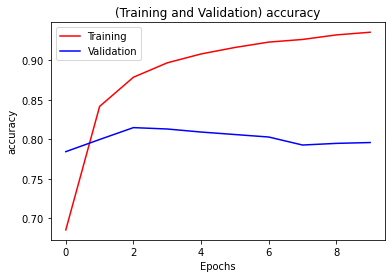

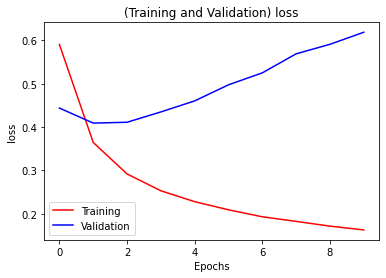

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def graph(history, title):
    line1, = plt.plot(epochs, history.history[title], 'r', label='Training')
    line2, = plt.plot(epochs, history.history['val_' + title], 'b', label='Validation')
    plt.legend(handles=[line1, line2])
    
    plt.ylabel(title)
    plt.xlabel("Epochs")
    
    plt.title("(Training and Validation) " + title)
    plt.figure()

graph(history, 'accuracy')
graph(history, 'loss')
plt.show()